#### Setting Up Framework

In [1]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0    612      0 --:--:-- --:--:-- --:--:--   612
Updating fastai...
Done.


In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 51.6MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

#### Retrieving Data From Kaggle

In [5]:
!pip install kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# enable interactions between Colab and Kaggle's API
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
  status, done = downloader.next_chunk()
  print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
# download move and unzip the dataset
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset
shutil.move("/content/the-simpsons-characters-dataset.zip","/content/data")
%cd /content/data

cp: cannot stat 'kaggle.json': No such file or directory
Download 100%.
100% 1.07G/1.08G [00:27<00:00, 48.9MB/s]
100% 1.08G/1.08G [00:27<00:00, 41.8MB/s]
/root/.fastai/data


In [ ]:
!unzip the-simpsons-characters-dataset.zip
#!unzip simpsons_dataset.zip
path = Path('/content/data/'); path

In [8]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [16]:
path = Path('/content/data/'); path
path_train = path/'simpsons_dataset'
path_test = path/'kaggle_simpson_testset'
path.ls()

[PosixPath('/content/data/weights.best.hdf5'),
 PosixPath('/content/data/kaggle_simpson_testset'),
 PosixPath('/content/data/simpsons_dataset'),
 PosixPath('/content/data/characters_illustration.png'),
 PosixPath('/content/data/annotation.txt'),
 PosixPath('/content/data/number_pic_char.csv'),
 PosixPath('/content/data/the-simpsons-characters-dataset.zip')]

In this particular dataset, labels are stored in the folders names.

* 42 folders, each representing one of the characters.
* The most popular characters (ie: The Simpson family) each have ~1,000 images, while lesser known characters have ~20–30 images.
To classify the images into the correct categories, I needed to first extract the labels from the folders names. To do so, I used the factory method [ImageDataBunch.from_folder()](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder).

In [17]:
data = ImageDataBunch.from_folder(path_train, ds_tfms=get_transforms(do_flip=False),size=224,bs=64,train='simpsons_dataset',valid_pct=0.2).normalize(imagenet_stats)

Checking if the labels were correctly extracted

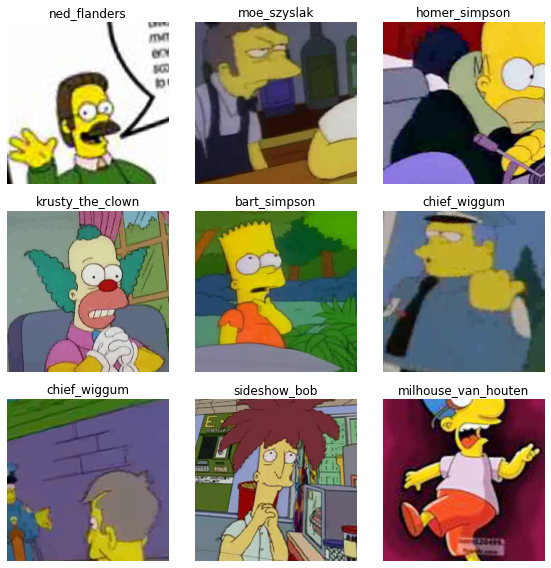

In [18]:
data.show_batch(rows = 3, figsize=(8,8))

In [19]:
print(data.classes)
len(data.classes),data.c

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


(42, 42)

#### Creating a Model


We will use fast.ai methodology and train our model. We will use a [convolutional neural network](http://http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier.

We will train for 4 epochs (4 cycles through all our data).

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.model

In [22]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.909584,0.496033,0.135196,08:37
1,0.504331,0.241662,0.066165,08:30
2,0.371145,0.171107,0.044667,08:47
3,0.289260,0.157709,0.042876,08:43


#### Results

Let's see what results we have got. The model has an accuracy of 96%!!!

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

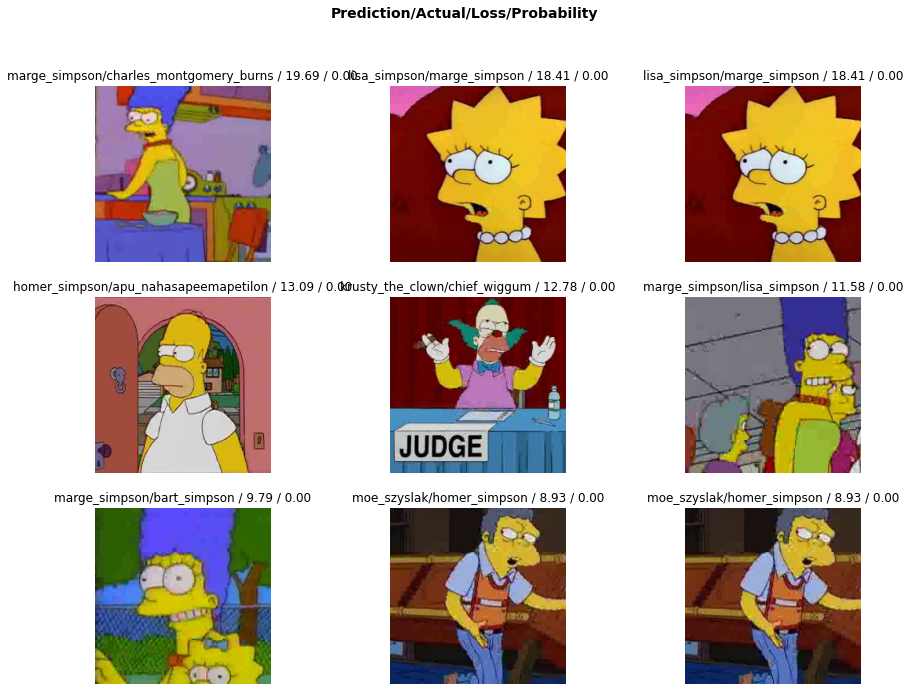

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

*The text above each images denotes: the prediction / the actual / the loss / the probability.*

Some of the images were mislabeled due to which this error occured. Plotting the confusion matrix.

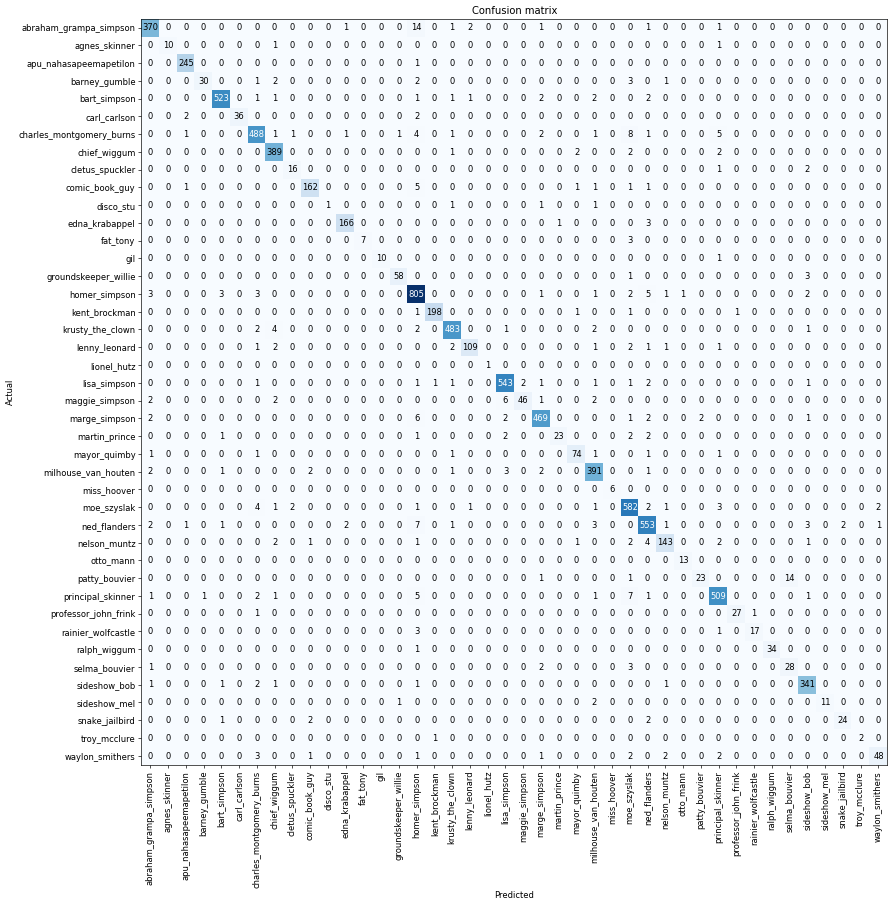

In [25]:
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)

The confusion matrix traced a diagonal, meaning the model correctly recognized most of the characters, even those of the least popular ones (unbalanced classes), with only 20–40 images. This was made possible thanks to a technique called transfer learning.

Indeed, I fitted a model that was pre-trained, meaning it already knew how to recognize images.

When I called create_cnn(data, models.resnet34, metrics=error_rate), it loaded a pre-trained resnet34 model which had already been trained to classify 1.5mn pictures across 1,000 different categories of objects (ie: plants, animals, people…)



#### Unfreezing the model

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [27]:
learn.unfreeze()

In [28]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.188097,0.078152,0.018154,09:00


In [30]:
learn.save('stage-1')

That's a pretty accurate model. 98% Accuracy!!!